[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cpeng2/repo/blob/main/Project_2_Peng.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Step 1: Load and split the data from Project 1

In [2]:
# load the file
url = "https://www.dropbox.com/scl/fi/ezo4vc5jfgwsd4o5ytrzz/LCA_Disclosure_Data_FY2025_Q3.csv?rlkey=kn6ewdyacyoh4nlz1r4jegxm0&dl=1"
h1b = pd.read_csv(url, low_memory=False)
print(h1b.head())

          CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
0  I-200-25181-143446   Withdrawn       6/30/25       6/30/25   
1  I-200-25181-141251   Withdrawn       6/30/25       6/30/25   
2  I-200-25181-142198   Withdrawn       6/30/25       6/30/25   
3  I-200-25181-138847   Withdrawn       6/30/25       6/30/25   
4  I-200-25181-140402   Withdrawn       6/30/25       6/30/25   

  ORIGINAL_CERT_DATE VISA_CLASS                              JOB_TITLE  \
0                NaN       H-1B                        Data Scientists   
1                NaN       H-1B  IT Technical Associate - Developer II   
2                NaN       H-1B                     Research Associate   
3                NaN       H-1B          Business Architecture Manager   
4                NaN       H-1B                         Senior Manager   

  SOC_CODE                                  SOC_TITLE FULL_TIME_POSITION  ...  \
0  15-2051                            Data Scientists                  Y  ...   
1 

In [3]:
# Explore "SOC_CODE" to create job categories
h1b[["SOC_CODE", "SOC_TITLE"]].head(50)
h1b["SOC_CODE"].dtype

dtype('O')

In [4]:
# Select features and drop NA
fea_col = ["CASE_STATUS", "VISA_CLASS", "SOC_CODE", "SOC_TITLE", "FULL_TIME_POSITION",
                   "EMPLOYER_CITY", "PREVAILING_WAGE", "EMPLOYER_NAME"]

h1b[fea_col].head(10)
h1b_no_missing = h1b[fea_col].dropna()
print(h1b_no_missing.shape)

(479005, 8)


In [5]:
# Split the data and use "stratify" to balance the data
X = h1b_no_missing[fea_col].drop("CASE_STATUS", axis=1)
y = h1b_no_missing["CASE_STATUS"]
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

CASE_STATUS
Certified                446456
Certified - Withdrawn     22002
Withdrawn                  7667
Denied                     2880
Name: count, dtype: int64


((383204, 7), (95801, 7))

Step 2: Prepare the data

In [6]:
# Identify categorical and numerical variables (columns)
cat_cols = ["VISA_CLASS", "SOC_CODE", "FULL_TIME_POSITION",
                   "EMPLOYER_CITY", "EMPLOYER_NAME"]
num_cols = ["PREVAILING_WAGE"]

Note: I used the SOC_CODE rather than the SOC_TITLE because extracting the first two digits of the SOC_CODE allows me to represent the job category as a categorical feature.

In [7]:
# extra the first 2 digits of SOC_CODE
X_train["SOC_CODE"] = X_train["SOC_CODE"].str.extract(r"(\d{2})", expand=False)
print(X_train["SOC_CODE"].value_counts().head(20))
X_train.head()

SOC_CODE
15    231787
17     38357
13     34023
11     21405
19     16140
29     16050
25     14138
27      4065
23      2469
41      2141
21      1833
43       194
53       186
49        88
35        86
45        67
31        62
51        47
39        30
47        15
Name: count, dtype: int64


,VISA_CLASS,SOC_CODE,SOC_TITLE,FULL_TIME_POSITION,EMPLOYER_CITY,PREVAILING_WAGE,EMPLOYER_NAME
121861,H-1B,15,Information Technology Project Managers,Y,EAST BRUNSWICK,"$62,338.00",WIPRO LIMITED
431833,H-1B,15,Software Developers,Y,Mountain View,"$137,259.00",Google LLC
381671,H-1B,15,Software Developers,Y,Minneapolis,"$141,751.00",U.S. Bank National Association
361413,H-1B,13,Management Analysts,Y,Washington,"$122,970.00",Japan International Transport and Tourism Inst...
289090,H-1B,15,Computer Programmers,Y,EAST BRUNSWICK,"$78,998.00",WIPRO LIMITED


In [8]:
# pipeline for numerical data
def extra_numbers(X):
    X = X.copy()
    X = X.replace('[$,]', '', regex=True)
    return pd.to_numeric(X.squeeze(), errors='coerce').to_frame()

num_pipeline = Pipeline([
    ("clean", FunctionTransformer(extra_numbers, validate=False)),
    ("scale", MaxAbsScaler())
])

In [9]:
# Combined the categorical and numerical data pipeline
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(sparse_output=True, handle_unknown="ignore"), cat_cols),
    ("num", num_pipeline, num_cols)
    ],
    # output as sparse to be memeory efficient
    sparse_threshold=1.0)

# fit the preprocessor and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)

(383204, 65268)
(95801, 65268)


Step 3: Examine target attribute

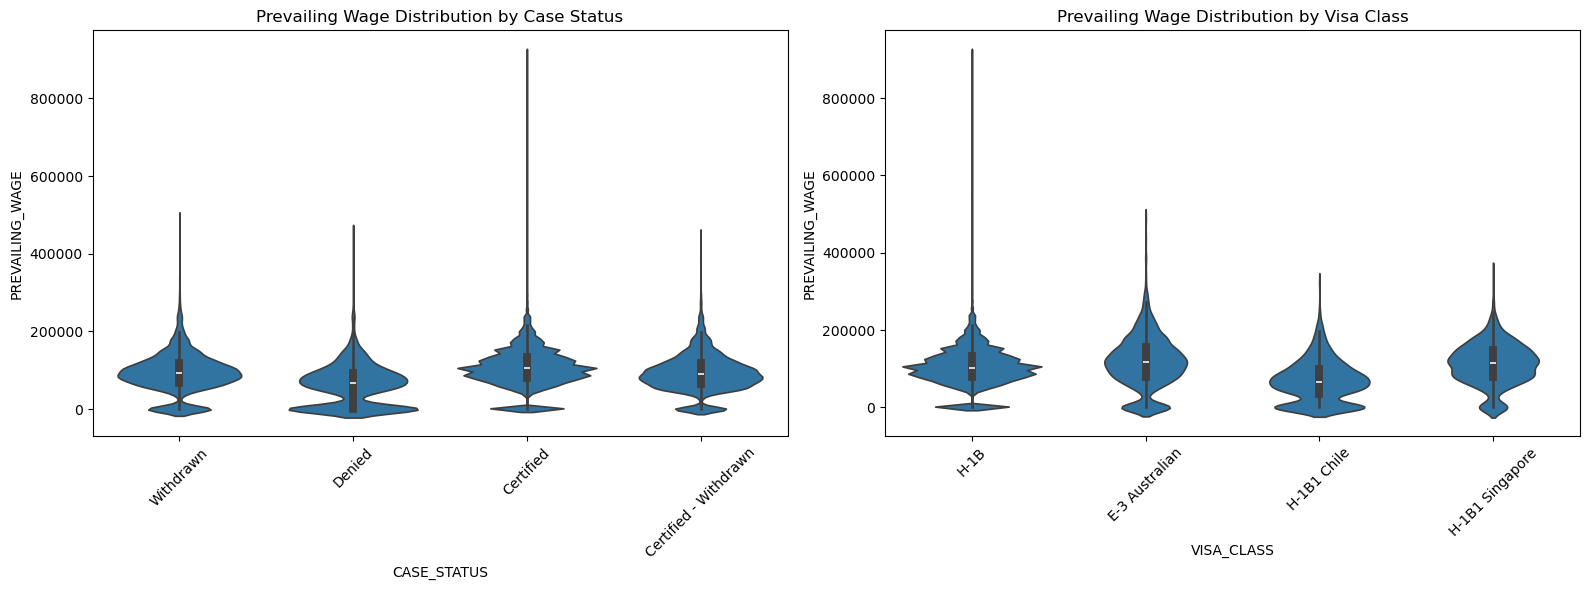

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

h1b_no_missing['PREVAILING_WAGE'] = extra_numbers(h1b_no_missing['PREVAILING_WAGE'])

# Prepare the figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

## Plot 1: Wage Distribution by Case Status
sns.violinplot(
    x='CASE_STATUS',
    y='PREVAILING_WAGE',
    data=h1b_no_missing,
    ax=axes[0]
)
axes[0].set_title('Prevailing Wage Distribution by Case Status')
axes[0].tick_params(axis='x', rotation=45)

## Plot 2: Wage Distribution by Visa Class
sns.violinplot(
    x='VISA_CLASS',
    y='PREVAILING_WAGE',
    data=h1b_no_missing,
    ax=axes[1]
)
axes[1].set_title('Prevailing Wage Distribution by Visa Class')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Step 4: Select 2 supervised learning algorithms

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

Note: Since my classification task primarily involves categorical variables, I selected Naive Bayes and Random Forest for this project. I also included an XGBoost model to compare its performance with that of the Random Forest.

Step 5: Default parameters, cross-validation, and adjusting parameters

1. Naive Bayes

In [12]:
# Train the Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train_processed, y_train)

# Evaluate the model
y_pred = mnb.predict(X_test_processed)
acc = mnb.score(X_test_processed, y_test)

print("Prediction Accuracy: {:.2f}".format(acc))
print(classification_report(y_test, y_pred))

Prediction Accuracy: 0.93
                       precision    recall  f1-score   support

            Certified       0.94      1.00      0.97     89291
Certified - Withdrawn       0.58      0.07      0.12      4400
               Denied       0.00      0.00      0.00       576
            Withdrawn       0.11      0.00      0.00      1534

             accuracy                           0.93     95801
            macro avg       0.41      0.27      0.27     95801
         weighted avg       0.90      0.93      0.91     95801



In [13]:
# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [14]:
# Cross validation on the training set

# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Run cross-validation (5 folds)
cv_results = cross_validate(
    mnb,
    X_train_processed,
    y_train_encoded,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# 4. Show results
print("Precision per fold:", cv_results['test_precision'])
print("Recall per fold:", cv_results['test_recall'])
print("F1 per fold:", cv_results['test_f1'])

print("\nAverage Precision:", cv_results['test_precision'].mean())
print("Average Recall:", cv_results['test_recall'].mean())
print("Average F1:", cv_results['test_f1'].mean())


Precision per fold: [0.3818332  0.29521422 0.37356272 0.4199999  0.29452734]
Recall per fold: [0.92926762 0.92950249 0.92920239 0.92955468 0.92931889]
F1 per fold: [0.90080342 0.90045877 0.9001198  0.90065745 0.90064968]

Average Precision: 0.3530274764693597
Average Recall: 0.9293692131336844
Average F1: 0.900537824605626


In [ ]:
# Tuning parameters with Grid Search

# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}
params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'fit_prior': [True, False]
}

grid_nb = GridSearchCV(
    mnb,
    params,
    cv=5,
    scoring=scoring,
    return_train_score=False,
    refit='precision' # Explicitly set refit to one of the scoring keys
)

# Use the encoded y_train_encoded instead of the original y_train
grid_nb.fit(X_train_processed, y_train_encoded)
print("Best parameters:{}".format(grid_nb.best_params_))
print("Best precision score:{:.2f}".format(grid_nb.best_score_))

Best parameters:{'alpha': 1, 'fit_prior': True}
precision_macro:0.35


2. Random Forest

In [16]:
# Train a Random Forest model
forest = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
forest.fit(X_train_processed, y_train)
y_pred = forest.predict(X_test_processed)
acc = forest.score(X_test_processed, y_test)

print("Prediction Accuracy: {:.2f}".format(acc))
print(classification_report(y_test, y_pred))

Prediction Accuracy: 0.93
                       precision    recall  f1-score   support

            Certified       0.94      0.99      0.96     89291
Certified - Withdrawn       0.46      0.08      0.14      4400
               Denied       0.26      0.04      0.07       576
            Withdrawn       0.11      0.01      0.02      1534

             accuracy                           0.93     95801
            macro avg       0.44      0.28      0.30     95801
         weighted avg       0.90      0.93      0.91     95801



In [ ]:
# Cross validation on the training set

# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Run cross-validation (5 folds)
cv_results = cross_validate(
    forest,
    X_train_processed,
    y_train_encoded,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Show results
print("Precision per fold:", cv_results['test_precision'])
print("Recall per fold:", cv_results['test_recall'])
print("F1 per fold:", cv_results['test_f1'])

print("\nAverage Precision:", cv_results['test_precision'].mean())
print("Average Recall:", cv_results['test_recall'].mean())
print("Average F1:", cv_results['test_f1'].mean())


Precision per fold: [0.43401378 0.42806726 0.43452241 0.42872519 0.41716959]
Recall per fold: [0.92488355 0.92326562 0.92350048 0.92437468 0.92343424]
F1 per fold: [0.91238693 0.91169286 0.91185001 0.91254255 0.91139867]

Average Precision: 0.42849964532671125
Average Recall: 0.9238917118363226
Average F1: 0.9119742071344008


In [18]:
def get_feature_names_from_ct(ct):
    """Extract feature names from a ColumnTransformer."""
    output = []

    for name, transformer, columns in ct.transformers_:
        if transformer == "drop":
            continue
        if transformer == "passthrough":
            output.extend(columns)
            continue

        try:
            names = transformer.get_feature_names_out(columns)
        except:
            names = [f"{name}__{col}" for col in columns]

        output.extend(names)

    return output


Note: I plot the most imporatant 10 features to compare with XGBoost.

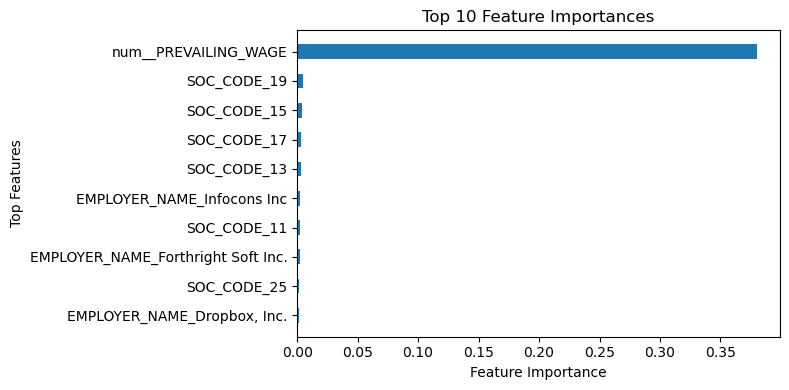

In [19]:
def plot_top_features(model, feature_names, top_n=20):

    # Get importance values
    importances = model.feature_importances_

    # Get indices of top N features
    indices = np.argsort(importances)[-top_n:]   # last N = largest N
    top_features = importances[indices]
    top_names = np.array(feature_names)[indices]

    # Sort them for a clean plot (small → large)
    order = np.argsort(top_features)
    top_features = top_features[order]
    top_names = top_names[order]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.barh(range(top_n), top_features, align='center', height=0.5)
    plt.yticks(range(top_n), top_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Top Features")
    plt.title(f"Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()

feature_names = get_feature_names_from_ct(preprocessor)
plot_top_features(forest, feature_names, top_n=10)


In [ ]:
# Tuning parameters with Grid Search
scoring = {
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

params_rf = {
    "n_estimators": [5, 10, 50, 100],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["log2", "sqrt"],
}

grid_rf = GridSearchCV(forest,
                       params_rf,
                       cv=5,
                       scoring=scoring,
                       refit="precision")

grid_rf.fit(X_train_processed, y_train_encoded)
print("Best parameters: {}".format(grid_rf.best_params_))
print("Best precision score: {:.2f}".format(grid_rf.best_score_))

3. XGBoost

In [ ]:
# Encode target variable for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train an XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train_processed, y_train_encoded)
y_pred_encoded = xgb.predict(X_test_processed)
acc = xgb.score(X_test_processed, y_test_encoded)

# Decode predictions for classification report
y_pred = le.inverse_transform(y_pred_encoded)

# Evaluate
print("Prediction Accuracy: {:.2f}".format(acc))
print(classification_report(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

#Get feature names for the plot
feature_names = get_feature_names_from_ct(preprocessor)
booster = xgb.get_booster()
booster.feature_names = feature_names

# Plot only the top 20 features for readability
plot_importance(
    booster,
    max_num_features=10,
    title='Top 20 XGBoost Feature Importance'
)
plt.figure(figsize=(150, 10))
plt.tight_layout()
plt.show()

Here are my preliminary findings:
1. Since most of the cases are approved, I'm using the the precision rates for denial and withdrawn as a measure of model perforamce.
2. Random forest model outperformed the Naive Bayes model.
3. Adjusting the parameters doesn't really change the model's performance much, but cluster the job titles into industries does improve the perforamce of the model.
4. "Prevailing wage" seems to be most import feature for both tree-based models.

